### **Detecção de armas em Escolas**
Copyright 2020 The GooGolPlex Authors.
Licensed under the Apache License, Version 2.0 (the "License");

*   Data Scientist Jose R F Junior - web2ajax@gmail.com
*   Project: Glock

In [0]:
!pip install tensorflow-gpu==2.0.0.alpha0

     |████████████████████████████████| 332.1MB 47kB/s 
     |████████████████████████████████| 419kB 15.0MB/s 
     |████████████████████████████████| 3.0MB 60.1MB/s 


In [0]:
!pip install tqdm

### Fazendo o download da base de dados de gatos e cachorros

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/'My Drive'/armas_and_nao_filtered.zip /content/

## Etapa 2: Pré-processamento

### Importação das bibliotecas

In [0]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.0.0-alpha0'

### Descompactando a base de dados das armas

In [0]:
!unzip /content/armas_and_nao_filtered.zip

Archive:  /content/armas_and_nao_filtered.zip
   creating: armas_and_nao_filtered/
   creating: armas_and_nao_filtered/train/
   creating: armas_and_nao_filtered/train/armas/
  inflating: armas_and_nao_filtered/train/armas/images(292)  
  inflating: armas_and_nao_filtered/train/armas/images(5)  
  inflating: armas_and_nao_filtered/train/armas/images(9)  
  inflating: armas_and_nao_filtered/train/armas/images(10)  
  inflating: armas_and_nao_filtered/train/armas/images(11)  
  inflating: armas_and_nao_filtered/train/armas/images(15)  
  inflating: armas_and_nao_filtered/train/armas/images(16)  
  inflating: armas_and_nao_filtered/train/armas/images(21)  
  inflating: armas_and_nao_filtered/train/armas/images(25)  
  inflating: armas_and_nao_filtered/train/armas/images(29)  
  inflating: armas_and_nao_filtered/train/armas/images(35)  
  inflating: armas_and_nao_filtered/train/armas/images(39)  
  inflating: armas_and_nao_filtered/train/armas/images(42)  
  inflating: armas_and_nao_filter

### Configurando os caminhos (paths)

In [0]:
%time
!pwd
dataset_path_new = "./armas_and_nao_filtered"

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
/content


In [0]:
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

In [0]:
train_arma_dir = os.path.join(train_dir, 'armas')  # directory with our training cat pictures
train_nao_dir = os.path.join(train_dir, 'nao')  # directory with our training dog pictures

validation_arma_dir = os.path.join(validation_dir, 'armas')  # directory with our validation cat pictures
validation_nao_dir = os.path.join(validation_dir, 'nao')  # directory with our validation dog pictures

### Entendendo os Dados

In [0]:
num_arma_tr = len(os.listdir(train_arma_dir))
num_nao_tr = len(os.listdir(train_nao_dir))

num_arma_val = len(os.listdir(validation_arma_dir))
num_nao_val = len(os.listdir(validation_nao_dir))

total_train = num_arma_tr + num_nao_tr
total_val = num_arma_val + num_nao_val

In [0]:
print('total training arma images:', num_arma_tr)
print('total training nao images:', num_nao_tr)

print('total validation arma images:', num_arma_val)
print('total validation nao images:', num_nao_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training arma images: 4730
total training nao images: 407
total validation arma images: 4730
total validation nao images: 407
--
Total training images: 5137
Total validation images: 5137


## Construindo o modelo

### Carregando o modelo pré-treinado (MobileNetV2)

In [0]:
img_shape = (128, 128, 3)

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Congelando o modelo base

In [0]:
base_model.trainable = False

### Definindo o cabeçalho personalizado da rede neural

In [0]:
base_model.output

<tf.Tensor 'out_relu/Relu6:0' shape=(None, 4, 4, 1280) dtype=float32>

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [0]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1280) dtype=float32>

In [0]:
prediction_layer = tf.keras.layers.Dense(units = 1, activation = "sigmoid")(global_average_layer)

### Definindo o modelo

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

### Compilando o modelo

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.0001),
              loss="binary_crossentropy", metrics = ["accuracy"])

### Criando geradores de dados (Data Generators)

Redimensionando as imagens

    Grandes arquiteturas treinadas suportam somente alguns tamanhos pré-definidos.

Por exemplo: MobileNet (que estamos usando) suporta: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224).

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [0]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), batch_size=128, class_mode="binary")
valid_generator = data_gen_train.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 4465 images belonging to 2 classes.
Found 4465 images belonging to 2 classes.


### Treinando o modelo

In [0]:
%time
model.fit_generator(train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5
35/35 [==============================] - 78s 2s/step - loss: 0.1660 - accuracy: 0.9523 - val_loss: 5.8613 - val_accuracy: 0.0224
Epoch 2/5
35/35 [==============================] - 40s 1s/step - loss: 0.0085 - accuracy: 0.9996 - val_loss: 5.5905 - val_accuracy: 0.0685
Epoch 3/5
35/35 [==============================] - 40s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.6122 - val_accuracy: 0.1059
Epoch 4/5
35/35 [==============================] - 40s 1s/step - loss: 2.6561e-04 - accuracy: 1.0000 - val_loss: 7.4198 - val_accuracy: 0.0999
Epoch 5/5
35/35 [==============================] - 40s 1s/step - loss: 5.3403e-05 - accuracy: 1.0000 - val_loss: 5.1615 - val_accuracy: 0.1704


### Avaliação do modelo de transferência de aprendizagem

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
valid_accuracy

0.17043673

## Visualize imagens de treinamento

In [0]:
sample_training_images, _ = next(valid_generator)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

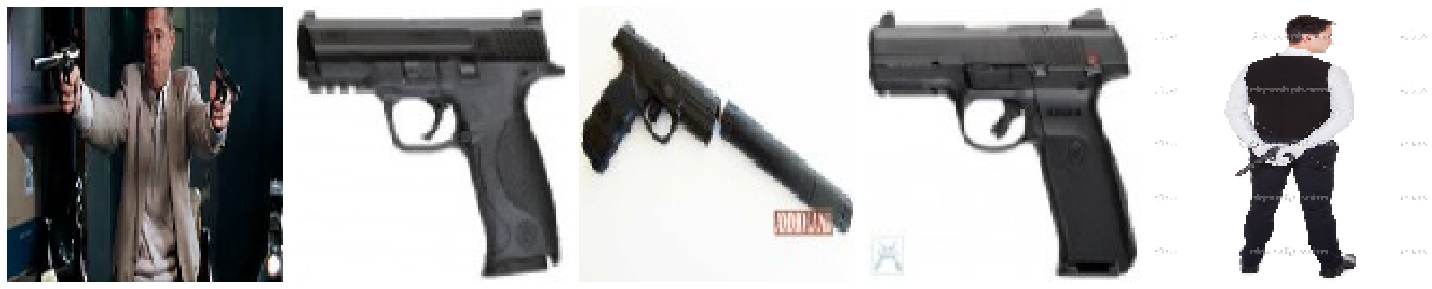

In [0]:
plotImages(sample_training_images[:5])

## Fine tuning


Duas questões principais:

- NÃO USE Fine Tuning em toda a rede neural, pois somente em algumas camadas já é suficiente. A ideia é adotar parte específica da rede neural para nosso problema específico
- Inicie o Fine Tuning DEPOIS que você finalizou a transferência de aprendizagem. Se você tentar o Fine Tuning imediatamente, os gradientes serão muito diferentes entre o cabeçalho personalizado e algumas camadas descongeladas do modelo base 

### Descongelando algumas camadas do topo do modelo base

In [0]:
base_model.trainable = True
len(base_model.layers)

155

In [0]:
fine_tuning_at = 100

In [0]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

### Compilando o modelo para fine tuning

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### Fine tuning

In [0]:
%time
model.fit_generator(train_generator, epochs=5, validation_data=valid_generator)

CPU times: user 25 µs, sys: 1 µs, total: 26 µs
Wall time: 52.2 µs
Epoch 1/5
35/35 [==============================] - 59s 2s/step - loss: 1.0086e-05 - accuracy: 1.0000 - val_loss: 4.0690 - val_accuracy: 0.2838
Epoch 2/5
35/35 [==============================] - 39s 1s/step - loss: 1.8349e-06 - accuracy: 1.0000 - val_loss: 2.9979 - val_accuracy: 0.3772
Epoch 3/5
35/35 [==============================] - 41s 1s/step - loss: 6.6977e-07 - accuracy: 1.0000 - val_loss: 1.5959 - val_accuracy: 0.5393
Epoch 4/5
35/35 [==============================] - 39s 1s/step - loss: 3.6046e-07 - accuracy: 1.0000 - val_loss: 0.7464 - val_accuracy: 0.7615
Epoch 5/5
35/35 [==============================] - 39s 1s/step - loss: 1.6473e-07 - accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.9122


### Avaliação do modelo com fine tuning

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
loss, accuracy = model.evaluate_generator(train_generator)

In [0]:
valid_accuracy

0.91220605

In [0]:
valid_loss

0.34556419891970497

In [0]:
loss

0.34580694351877483

In [0]:
accuracy

0.91220605

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
print('Loss:', loss)
print('Accuracy:', accuracy)

Loss: 0.34580694351877483
Accuracy: 0.91220605


In [0]:
train_generator.class_indices

{'armas': 0, 'nao': 1}

In [0]:
#@Caminho do arquivo, da imagem para testar
filename = "/content/armas_and_nao_filtered/validation/armas/0.66-500x500.jpg" #@param {type:"string"}

img = image.load_img(filename, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("Positivo: ", actual, "\n", "Previsao: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)



NameError: ignored

## Etapa 5: Salvando o modelo para produção

### Criando o diretório para o modelo

In [0]:
!pwd
!mkdir model
model_dir = "/content/model/"
version = 1

/content


In [0]:
export_path = os.path.join(model_dir, str(version))
export_path

'/content/model/1'

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Salvando o modelo para o TensorFlow Serving

In [0]:
model.input

<tf.Tensor 'input_1:0' shape=(None, 128, 128, 3) dtype=float32>

In [0]:
model.outputs

[<tf.Tensor 'dense/Sigmoid:0' shape=(None, 1) dtype=float32>]

In [0]:
o = {t.name: t for t in model.outputs}

In [0]:
o

{'dense/Sigmoid:0': <tf.Tensor 'dense/Sigmoid:0' shape=(None, 1) dtype=float32>}

In [0]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir = export_path,
                           inputs = {"input_image": model.input},
                           outputs = {t.name: t for t in model.outputs})

AttributeError: ignored

In [0]:
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

## Etapa 6: Configuração do ambiente de produção

### Exportando o MODEL_DIR para as variáveis de ambiente

In [0]:
os.environ["model_dir"] = os.path.abspath(model_dir)